In [1]:
import os
import random
import pathlib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

440742/440742 [==============================] - 1s 3us/step


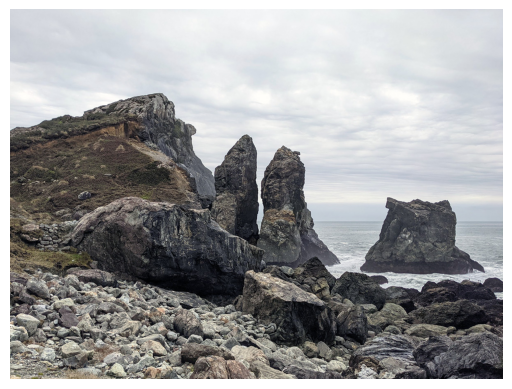

In [2]:
base_image_path = keras.utils.get_file("coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

In [3]:
model = tf.keras.applications.inception_v3.InceptionV3(weights="imagenet", include_top=False)

In [9]:
layer_settings = {  # 1-9
    "mixed4": 3.0,
    "mixed5": 1.5,
    "mixed6": 1.2,
    "mixed7": 1.5,
}
outputs_dict = dict([(layer.name, layer.output) for layer in [model.get_layer(name)
                                                for name in layer_settings.keys()]])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)
# model.summary()

In [10]:
def compute_loss(input_image):  # Compute all mixed layers
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

@tf.function
def gradient_ascent_step(image, learning_rate):  # Gradient image weights
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image

def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

Processing octave 0 with shape (409, 546)
... Loss value at step 0: 1.11
... Loss value at step 1: 1.47
... Loss value at step 2: 2.07
... Loss value at step 3: 2.78
... Loss value at step 4: 3.43
... Loss value at step 5: 4.17
... Loss value at step 6: 4.86
... Loss value at step 7: 5.61
... Loss value at step 8: 6.28
... Loss value at step 9: 7.00
... Loss value at step 10: 7.76
... Loss value at step 11: 8.37
... Loss value at step 12: 9.06
... Loss value at step 13: 9.76
... Loss value at step 14: 10.43
... Loss value at step 15: 11.09
... Loss value at step 16: 11.80
... Loss value at step 17: 12.54
... Loss value at step 18: 13.17
... Loss value at step 19: 13.89
... Loss value at step 20: 14.52
Processing octave 1 with shape (532, 710)
... Loss value at step 0: 2.39
... Loss value at step 1: 4.22
... Loss value at step 2: 5.61
... Loss value at step 3: 6.80
... Loss value at step 4: 7.83
... Loss value at step 5: 8.85
... Loss value at step 6: 9.80
... Loss value at step 7: 10.7

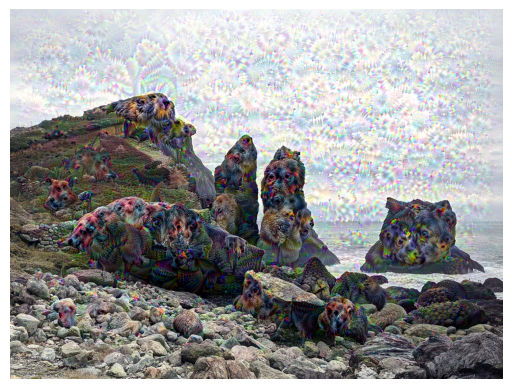

In [11]:
step_lr = 20.
num_octave = 4
octave_scale = 1.3
iterations = 30
max_loss = 15.

original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):  # Octave 1.4**i rescale
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])
img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):  # Main cycle
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step_lr, max_loss=max_loss)
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

# keras.utils.save_img("dream.png", deprocess_image(img.numpy()))
depr_img = deprocess_image(img.numpy())
plt.axis("off")
plt.imshow(depr_img)